In [1]:
import os
import glob
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [2]:
!sh -c 'ls sca/*-#0.sca 1>/dev/null 2>&1 && for f in sca/*-#0.sca; do mv "$f" "${f%-#0.sca}.sca"; done || echo "not found"'

not found


In [3]:
cw_fl ='csv/Wired-2_cwUsed.csv'
dataError_fl = 'csv/Wired-2_DataErrorRate.csv'
hdrError_fl = 'csv/Wired-2_HeaderErrorRate.csv'
udp_fl ='csv/Wired-2_udpPacketTransmissionInfo.csv'
sca_fl = 'sca/Wired-2.sca'

In [4]:
cw_df = pd.read_csv(cw_fl)
dataError_df = pd.read_csv(dataError_fl)
hdrError_df = pd.read_csv(hdrError_fl)
udp_df = pd.read_csv(udp_fl)

with open(sca_fl, 'r') as f:
    sca = f.read()

print('cw_df:', cw_df.shape)
print('dataError_df:', dataError_df.shape)
print('hdrError_df:', hdrError_df.shape)
print('udp_df:', udp_df.shape)
print('sca:', (len(sca.split('\n'))))

cw_df: (401, 3)
dataError_df: (0, 5)
hdrError_df: (0, 5)
udp_df: (5332, 5)
sca: 2827


In [5]:
wired_match = re.search(r'param.*num_wired\s+(\d+)', sca).group(1)
wired = int(wired_match)
print(wired)

2


In [6]:
# scalar WiredAndWirelessHostsWithAP.wiredHost[0].udp packetSent:count 2666
wired_sent_pattern = r'scalar WiredAndWirelessHostsWithAP\.wiredHost\[0\]\.udp packetSent:count (\d+)'
wired_sent_count = int(re.search(wired_sent_pattern, sca).group(1))
print(wired_sent_count)

2666


In [7]:
# scalar WiredAndWirelessHostsWithAP.sinkNode.udp packetReceived:count 37324
sink_received_pattern = r'scalar WiredAndWirelessHostsWithAP\.sinkNode\.udp packetReceived:count (\d+)'
sink_received_count = int(re.search(sink_received_pattern, sca).group(1))
print(sink_received_count)

5332


In [8]:
# scalar WiredAndWirelessHostsWithAP.sinkNode.udp packetReceived:sum(packetBytes) 2772640
received_bytes_pattern = r'scalar WiredAndWirelessHostsWithAP\.sinkNode\.udp packetReceived:sum\(packetBytes\) (\d+)'
received_bytes_count = int(re.search(received_bytes_pattern, sca).group(1))
print(received_bytes_count)

2772640


In [9]:
with open ("sca/Wireless-4.sca", 'r') as f:
    wirelessca = f.read()

In [10]:
packets_per_host_pattern = r'scalar WiredAndWirelessHostsWithAP\.wirelessHost\[0\]\.app\[0\] "packets sent" (\d+)'
packets_per_host = int(re.search(packets_per_host_pattern, wirelessca).group(1))
print(packets_per_host)

2666


In [11]:
def get_metrics_wireless(cw_path, dataerr_path, headererr_path, udpinfo_path, scalar_path, runtime=40):

    # Load CSV files into DataFrames
    cw_df = pd.read_csv(cw_path)
    dataError_df = pd.read_csv(dataerr_path)
    hdrError_df = pd.read_csv(headererr_path)
    udp_df = pd.read_csv(udpinfo_path)

    # Read scalar file
    with open(scalar_path, 'r') as f:
        sca = f.read()

    # 1. Number of Devices
    wireless_match = re.search(r'param.*num_wireless\s+(\d+)', sca).group(1)
    total_hosts = int(wireless_match)

    # 2. Packet Delivery Ratio (PDR)
    num_packets_received = udp_df.shape[0]
    packets_per_host_pattern = r'scalar WiredAndWirelessHostsWithAP\.wirelessHost\[0\]\.app\[0\] "packets sent" (\d+)'
    packets_per_host = int(re.search(packets_per_host_pattern, sca).group(1))
    total_packets_sent = packets_per_host * total_hosts
    PDR = (num_packets_received / total_packets_sent) * 100

    # 3. Throughput (bps)
    sink_bytes_pattern = r'scalar WiredAndWirelessHostsWithAP\.sinkNode\.udp packetReceived:sum\(packetBytes\) (\d+)'
    sink_bytes_received = int(re.search(sink_bytes_pattern, sca).group(1))
    throughput_bps = (sink_bytes_received * 8) / runtime

    # 4. MAC-layer Retransmission Rate
    cw_df = cw_df.sort_values(['Node', 'Simulation Time'])
    retransmissions = 0
    total_transmissions = 0
    for node, group in cw_df.groupby('Node'):
        cw = group['Contetion Size'].to_numpy()
        retrans = (cw[1:] > cw[:-1]).sum()
        retransmissions += retrans
        total_transmissions += len(cw)
    retrans_rate = (retransmissions / total_transmissions) * 100 if total_transmissions > 0 else 0 # div by 0

    # 5. Bit Error Rate (BER)
    h_len = hdrError_df['Header Length']
    d_len = dataError_df['Data Length']
    BER_h = hdrError_df['Error rate']
    BER_d = dataError_df['Error rate']
    BER_packet = (BER_h * h_len + BER_d * d_len) / (h_len + d_len)
    overall_ber = BER_packet.mean()

    # 6. End-to-End Delay
    delay_min = udp_df['Delay'].min()
    delay_max = udp_df['Delay'].max()
    delay_avg = udp_df['Delay'].mean()

    # # 7. Msg Length, Send Interval
    # message_length_pattern = r'param \*\*\.\*Host\[\*\]\.app\[0\]\.messageLength\s+(\d+)([a-zA-Z]*)'
    # send_interval_pattern = r'param \*\*\.\*Host\[\*\]\.app\[0\]\.sendInterval\s+([\d\.]+)([a-zA-Z]*)'

    # message_length_match = re.search(message_length_pattern, sca)
    # send_interval_match = re.search(send_interval_pattern, sca)

    # message_length = f"{message_length_match.group(1)}{message_length_match.group(2)}" if message_length_match else "N/A"
    # send_interval = f"{send_interval_match.group(1)}{send_interval_match.group(2)}" if send_interval_match else "N/A"

    # # 8. DCF Parameters
    # # CW Min
    # cwmin_pattern = r'param \*\*\.\*Host\[\*\]\.wlan\[\*\]\.mac\.dcf\.channelAccess\.cwMin\s+(\d+)'
    # cwmin_match = re.search(cwmin_pattern, sca)
    # cw_min = cwmin_match.group(1) if cwmin_match else "N/A"

    # # CW Max
    # cwmax_pattern = r'param \*\*\.\*Host\[\*\]\.wlan\[\*\]\.mac\.dcf\.channelAccess\.cwMax\s+(\d+)'
    # cwmax_match = re.search(cwmax_pattern, sca)
    # cw_max = cwmax_match.group(1) if cwmax_match else "N/A"

    # # Short Retry Limit
    # retry_pattern = r'param \*\*\.\*Host\[\*\]\.wlan\[\*\]\.mac\.dcf\.recoveryProcedure\.shortRetryLimit\s+(\d+)'
    # retry_match = re.search(retry_pattern, sca)
    # retry_limit = retry_match.group(1) if retry_match else "N/A"

    # # RTS Threshold
    # rts_pattern = r'param \*\*\.\*Host\[\*\]\.wlan\[\*\]\.mac\.dcf\.rtsPolicy\.rtsThreshold\s+(\d+)([a-zA-Z]*)'
    # rts_match = re.search(rts_pattern, sca)
    # rts_threshold = f"{rts_match.group(1)}{rts_match.group(2)}" if rts_match else "N/A"

    # Return metrics rounded to 2 decimal places
    return {
        "Num Devices": total_hosts,
        "PDR (%)": round(PDR, 2),
        "Throughput (bps)": round(throughput_bps, 2),
        "MAC Retransmission Rate (%)": round(retrans_rate, 2),
        "BER (%)": round(overall_ber * 100, 2),
        "End-to-End Delay (Max)": round(delay_max, 6) if delay_max is not None else None,
        "End-to-End Delay (Min)": round(delay_min, 6) if delay_min is not None else None,
        "End-to-End Delay (Avg)": round(delay_avg, 6) if delay_avg is not None else None,
        # "Message Length": message_length,
        # "Send Interval": send_interval,
        # "CW Min": cw_min,
        # "CW Max": cw_max,
        # "Retry Limit": retry_limit,
        # "RTS Threshold": rts_threshold
    }

In [12]:
def get_metrics_wired(cw_path, dataerr_path, headererr_path, udpinfo_path, scalar_path, runtime=40):

    # Load CSV files into DataFrames
    cw_df = pd.read_csv(cw_path)
    dataError_df = pd.read_csv(dataerr_path)
    hdrError_df = pd.read_csv(headererr_path)
    udp_df = pd.read_csv(udpinfo_path)

    # Read scalar file
    with open(scalar_path, 'r') as f:
        sca = f.read()

    # 1. Number of Devices
    wired_match = re.search(r'param.*num_wired\s+(\d+)', sca).group(1)
    wired_devices = int(wired_match)

    # 2. Packet Delivery Ratio (PDR)
    sink_received_pattern = r'scalar WiredAndWirelessHostsWithAP\.sinkNode\.udp packetReceived:count (\d+)'
    sink_received_count = int(re.search(sink_received_pattern, sca).group(1))
    # print(sink_received_count)

    wired_sent_pattern = r'scalar WiredAndWirelessHostsWithAP\.wiredHost\[0\]\.udp packetSent:count (\d+)'
    wired_sent_count = int(re.search(wired_sent_pattern, sca).group(1))
    # print(wired_sent_count)

    total_packets_sent = wired_sent_count * wired_devices
    PDR = (sink_received_count / total_packets_sent) * 100

    # 3. Throughput (bps)
    received_bytes_pattern = r'scalar WiredAndWirelessHostsWithAP\.sinkNode\.udp packetReceived:sum\(packetBytes\) (\d+)'
    received_bytes_count = int(re.search(received_bytes_pattern, sca).group(1))
    # print(received_bytes_count)
    throughput_bps = (received_bytes_count * 8) / runtime

    # 4. MAC-layer Retransmission Rate
    cw_df = cw_df.sort_values(['Node', 'Simulation Time'])
    retransmissions = 0
    total_transmissions = 0
    for node, group in cw_df.groupby('Node'):
        cw = group['Contetion Size'].to_numpy()
        retrans = (cw[1:] > cw[:-1]).sum()
        retransmissions += retrans
        total_transmissions += len(cw)
    retrans_rate = (retransmissions / total_transmissions) * 100 if total_transmissions > 0 else 0 # div by 0

    # 5. Bit Error Rate (BER)
    h_len = hdrError_df['Header Length']
    d_len = dataError_df['Data Length']
    BER_h = hdrError_df['Error rate']
    BER_d = dataError_df['Error rate']
    BER_packet = (BER_h * h_len + BER_d * d_len) / (h_len + d_len)
    overall_ber = BER_packet.mean()

    # 6. End-to-End Delay
    delay_min = udp_df['Delay'].min()
    delay_max = udp_df['Delay'].max()
    delay_avg = udp_df['Delay'].mean()

    # Return metrics rounded to 2 decimal places
    return {
        "Num Devices": wired_devices,
        "PDR (%)": round(PDR, 2),
        "Throughput (bps)": round(throughput_bps, 2),
        "MAC Retransmission Rate (%)": round(retrans_rate, 2),
        "BER (%)": round(overall_ber * 100, 2),
        "End-to-End Delay (Max)": round(delay_max, 6) if delay_max is not None else None,
        "End-to-End Delay (Min)": round(delay_min, 6) if delay_min is not None else None,
        "End-to-End Delay (Avg)": round(delay_avg, 6) if delay_avg is not None else None,
        # "Message Length": message_length,
        # "Send Interval": send_interval,
        # "CW Min": cw_min,
        # "CW Max": cw_max,
        # "Retry Limit": retry_limit,
        # "RTS Threshold": rts_threshold
    }

In [13]:
def get_df(step_prefix, start, end, jump=1, file_format="{}", wireless=True):

    metrics_list = []
    
    for i in range(start, end + 1, jump):
        cfg = file_format.format(i)
        
        # Construct file paths
        cw_path = f'csv/{step_prefix}-{cfg}_cwUsed.csv'
        dataerr_path = f'csv/{step_prefix}-{cfg}_DataErrorRate.csv'
        headererr_path = f'csv/{step_prefix}-{cfg}_HeaderErrorRate.csv'
        udpinfo_path = f'csv/{step_prefix}-{cfg}_udpPacketTransmissionInfo.csv'
        scalar_path = f'sca/{step_prefix}-{cfg}.sca'
        
        # Check if all files exist
        file_paths = [cw_path, dataerr_path, headererr_path, udpinfo_path, scalar_path]
        if not all(os.path.exists(path) for path in file_paths):
            print(f"Skipping {step_prefix}-{cfg}: One or more files are missing.")
            continue
        
        # Call the function and append the results to the list
        try:
            if wireless:
                metrics = get_metrics_wireless(cw_path, dataerr_path, headererr_path, udpinfo_path, scalar_path)
                metrics_list.append(metrics)
            else:
                metrics = get_metrics_wired(cw_path, dataerr_path, headererr_path, udpinfo_path, scalar_path)
                metrics_list.append(metrics)
        except Exception as e:
            print(f"Error processing {step_prefix}-{cfg}: {e}")
            continue
    
    # Convert the list of metrics into a DataFrame
    return pd.DataFrame(metrics_list)

In [14]:
wired_df = get_df("Wired", 2, 14, jump=2, file_format="{}", wireless=False)
wired_df

,Num Devices,PDR (%),Throughput (bps),MAC Retransmission Rate (%),BER (%),End-to-End Delay (Max),End-to-End Delay (Min),End-to-End Delay (Avg)
0,2,100.0,554528.0,0.0,NaN,0.000217,0.000136,0.000159
1,4,100.0,1109056.0,0.0,NaN,0.000310,0.000136,0.000205
2,6,100.0,1663584.0,0.0,NaN,0.000402,0.000136,0.000252
3,8,100.0,2218112.0,0.0,NaN,0.000495,0.000136,0.000298
4,10,100.0,2772640.0,0.0,NaN,0.000587,0.000136,0.000344
5,12,100.0,3327168.0,0.0,NaN,0.000679,0.000136,0.000390
6,14,100.0,3881696.0,0.0,NaN,0.000772,0.000136,0.000437


In [15]:

wireless_df = get_df("Wireless", 2, 14, jump=2, file_format="{}", wireless=True)
wireless_df

,Num Devices,PDR (%),Throughput (bps),MAC Retransmission Rate (%),BER (%),End-to-End Delay (Max),End-to-End Delay (Min),End-to-End Delay (Avg)
0,2,100.00,554528.0,47.78,5.59,1.023471,0.005346,0.028725
1,4,99.98,1108848.0,41.47,2.69,1.300117,0.002542,0.108708
2,6,71.58,1190800.0,27.68,4.87,5.040595,0.832259,1.940173
3,8,51.69,1146496.0,32.46,5.71,5.566095,0.947416,2.728443
4,10,40.58,1125176.0,35.28,7.02,8.388993,0.922395,3.435758
5,12,33.74,1122472.0,36.52,7.28,9.094648,0.829674,4.104817
6,14,28.91,1122264.0,37.73,7.48,11.542467,0.857509,4.726949


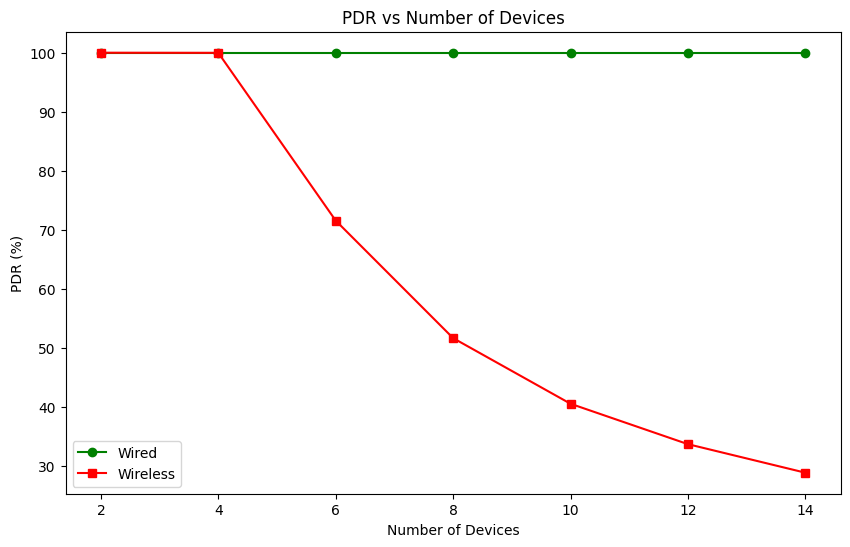

In [16]:
plt.figure(figsize=(10, 6))

plt.plot(wired_df['Num Devices'], wired_df['PDR (%)'], label='Wired', marker='o', color='green')
plt.plot(wireless_df['Num Devices'], wireless_df['PDR (%)'], label='Wireless', marker='s', color='red')

# Add labels and title
plt.xlabel('Number of Devices')
plt.ylabel('PDR (%)')
plt.title('PDR vs Number of Devices')
plt.legend()

# Show the plot
plt.show()

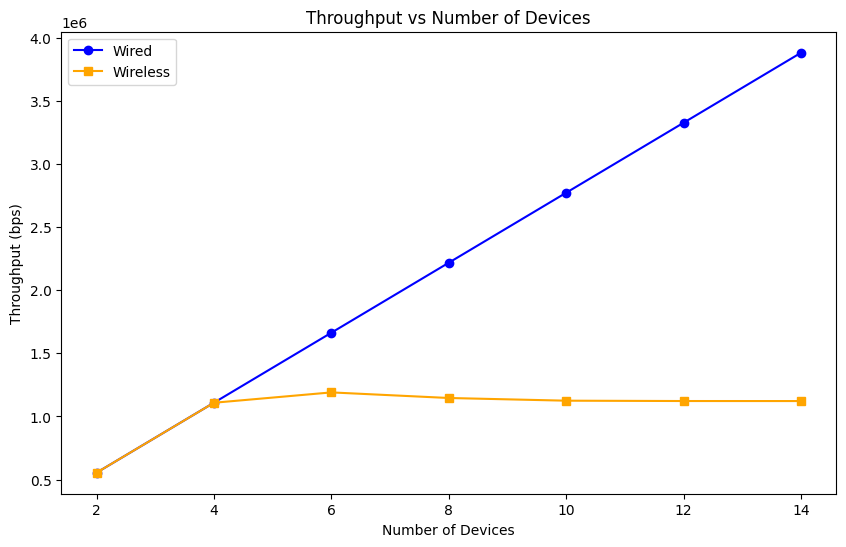

In [17]:
plt.figure(figsize=(10, 6))

plt.plot(wired_df['Num Devices'], wired_df['Throughput (bps)'], label='Wired', marker='o', color='blue')
plt.plot(wireless_df['Num Devices'], wireless_df['Throughput (bps)'], label='Wireless', marker='s', color='orange')

# Add labels and title
plt.xlabel('Number of Devices')
plt.ylabel('Throughput (bps)')
plt.title('Throughput vs Number of Devices')
plt.legend()

# Show the plot
plt.show()

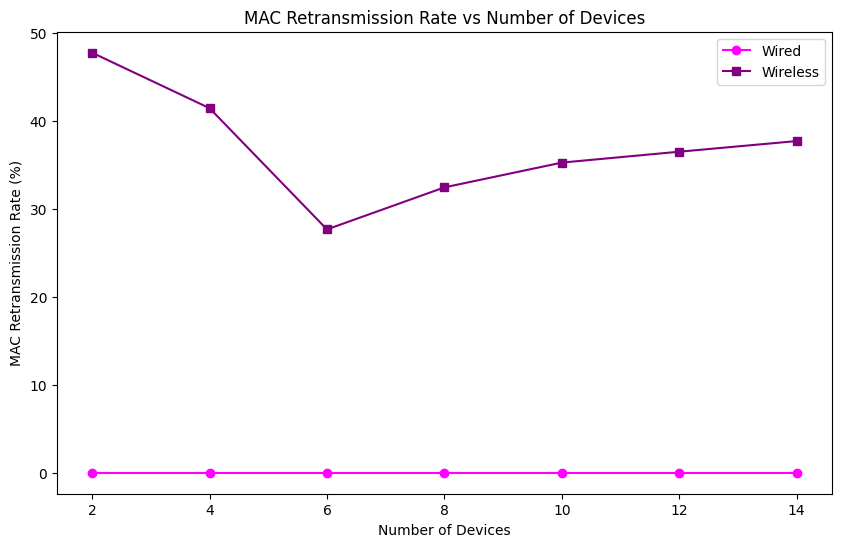

In [18]:
plt.figure(figsize=(10, 6))

plt.plot(wired_df['Num Devices'], wired_df['MAC Retransmission Rate (%)'], label='Wired', marker='o', color='magenta')
plt.plot(wireless_df['Num Devices'], wireless_df['MAC Retransmission Rate (%)'], label='Wireless', marker='s', color='purple')

# Add labels and title
plt.xlabel('Number of Devices')
plt.ylabel('MAC Retransmission Rate (%)')
plt.title('MAC Retransmission Rate vs Number of Devices')
plt.legend()

# Show the plot
plt.show()

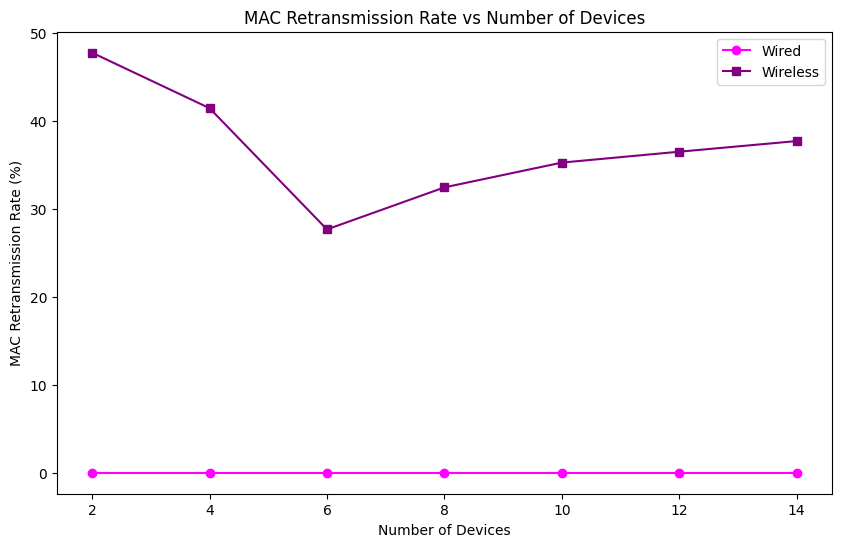

In [19]:
plt.figure(figsize=(10, 6))

plt.plot(wired_df['Num Devices'], wired_df['MAC Retransmission Rate (%)'], label='Wired', marker='o', color='magenta')
plt.plot(wireless_df['Num Devices'], wireless_df['MAC Retransmission Rate (%)'], label='Wireless', marker='s', color='purple')

# Add labels and title
plt.xlabel('Number of Devices')
plt.ylabel('MAC Retransmission Rate (%)')
plt.title('MAC Retransmission Rate vs Number of Devices')
plt.legend()

# Show the plot
plt.show()

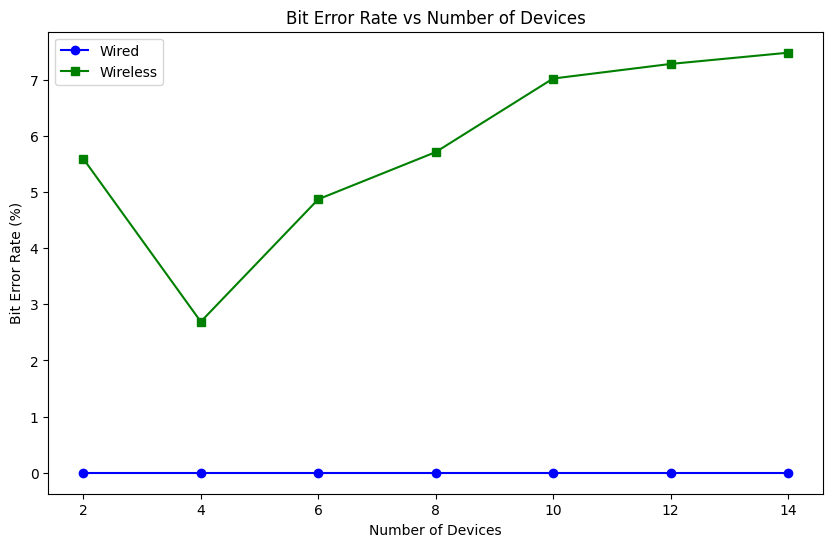

In [20]:
plt.figure(figsize=(10, 6))

# handle nan
plt.plot(wired_df['Num Devices'], wired_df['BER (%)'].fillna(0), label='Wired', marker='o', color='blue')
plt.plot(wireless_df['Num Devices'], wireless_df['BER (%)'], label='Wireless', marker='s', color='green')

# Add labels and title
plt.xlabel('Number of Devices')
plt.ylabel('Bit Error Rate (%)')
plt.title('Bit Error Rate vs Number of Devices')
plt.legend()

# Show the plot
plt.show()

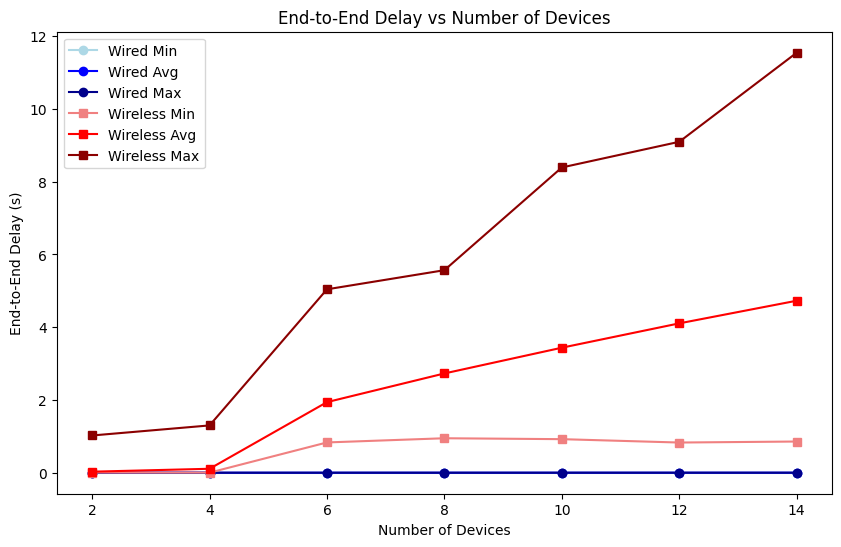

In [21]:
plt.figure(figsize=(10, 6))

# Plot wired delays with blue shades
plt.plot(wired_df['Num Devices'], wired_df['End-to-End Delay (Min)'], label='Wired Min', marker='o', color='lightblue')
plt.plot(wired_df['Num Devices'], wired_df['End-to-End Delay (Avg)'], label='Wired Avg', marker='o', color='blue')
plt.plot(wired_df['Num Devices'], wired_df['End-to-End Delay (Max)'], label='Wired Max', marker='o', color='darkblue')

# Plot wireless delays with red shades
plt.plot(wireless_df['Num Devices'], wireless_df['End-to-End Delay (Min)'], label='Wireless Min', marker='s', color='lightcoral')
plt.plot(wireless_df['Num Devices'], wireless_df['End-to-End Delay (Avg)'], label='Wireless Avg', marker='s', color='red')
plt.plot(wireless_df['Num Devices'], wireless_df['End-to-End Delay (Max)'], label='Wireless Max', marker='s', color='darkred')

# Add labels and title
plt.xlabel('Number of Devices')
plt.ylabel('End-to-End Delay (s)')
plt.title('End-to-End Delay vs Number of Devices')
plt.legend()

# Show the plot
plt.show()